In [2]:
import numpy as np
import tensorflow as tf

import sys
sys.path.append("..")


try:
    import matplotlib.pyplot as plt
    %matplotlib inline
except:
    pass

try:
    from mpl_toolkits.mplot3d import Axes3D
except:
    pass

In [3]:
# utility function  to reset the TF graph to the same state each time
def reset_graph(seed=42):
    # to make results reproducible across runs
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)
    

In [5]:
class Tobit_Regression:
    
    def __init__(self, n_features, learning_rate=0.005, L=0):
        
        self.input = tf.placeholder(tf.float32, [None, n_features], name="Input")
        self.target = tf.placeholder(tf.float32, [None, 1], name="Target")
        
        # the first weight is for the intercept, the last one is for a square root of the noise std 
        self.weights = tf.Variable(tf.random_normal([n_features + 2, 1]))
        
        # Augmented data matrix is obtained by adding a column of ones to the data matrix
        self.data_plus_bias = tf.concat([tf.ones([tf.shape(self.input)[0], 1]), self.input], axis=1)

        #######################################################################
        # MLE for Tobit regression 
        
        # noise volatility is obtained as a square of the last weight to ensure positivity 
        self.sigma = 0.0001 + tf.square(self.weights[-1])
        
        # term1 and term2 are just placeholders initialized such that the code runs
        
        term1 = tf.Variable(np.zeros(shape=(n_features + 2, 1)))
        term2 = tf.Variable(np.zeros(shape=(n_features + 2, 1)))
        
        # OF THE TOBIT REGRESSION MODEL
        
        # calculation of loss function 
        # (the negative log-likelihood)
        
        self.y_out = tf.matmul(self.data_plus_bias[:, :], self.weights[:-1])
        norm = tf.distributions.Normal(loc=0.0, scale=1.0)
        term1 = tf.to_float(self.target > L) * tf.log(0.00001 + 1/self.sigma * norm.prob((self.target - self.y_out)/self.sigma))
        term2 = (1-tf.to_float(self.target > L)) * tf.log(0.00001 + 1 - norm.cdf((self.y_out - L)/self.sigma))
        
        
        self.loss = - tf.reduce_mean(term1 + term2)
        
        #####################################################################

        # Use Adam optimization for training
        self.train_step = (tf.train.AdamOptimizer(learning_rate).minimize(self.loss), -self.loss)
        
        # prediction made from the model: Use a ReLU neuron!
        self.output = tf.nn.relu(tf.matmul(self.data_plus_bias[:, :], self.weights[:-1]))
        
        # Check the output L1-norm error  
        self.output_L1_error = tf.reduce_mean(tf.abs(self.target - self.output))

    def generate_data(n_points,
                      n_features,
                      weights,
                      noise_std):

        # Bounds of [-1,1] in space of n_points x n_features
        np.random.seed(42)
        bias = np.ones(n_points).reshape((-1,1))
        low = - np.ones((n_points,n_features),'float')
        high = np.ones((n_points,n_features),'float')

        # simulated features are uniformally distributed on [-1,1].
        # The size n_points x n_features of array X is inferred by broadcasting of 'low' and 'high'
        X = np.random.uniform(low=low, high=high)
        
        # simulated noise
        noise = np.random.normal(size=(n_points, 1))
        
        # outputs    
        Y = weights[0] * bias + np.dot(X, weights[1:]).reshape((-1,1)) + noise_std * noise

        # truncate negative values of Y    
        np.clip(Y, a_min=0, a_max=None, out=Y)

        return X, Y    

In [6]:
def gen_tobit_dataset(n_points, n_features, train_test_split=4):
    """
    Generate dataset for Tobit regression model and split it into training and test portions
    
    """
    # n_features + 1 weights (one for a constant feature)
    data_weights = np.array([-0.25, 0.5, 0.2, .1]) 
    noise_std = 0.1
    
    # Generate dataset
    X, Y = Tobit_Regression.generate_data(n_points=n_points,
                                           n_features=n_features,
                                           weights=data_weights,
                                           noise_std=noise_std)
    
    # split to the train and test set
    # 1/4 of the data is used for a test
    
    n_test = int(n_points / train_test_split)
    n_train = n_points - n_test
    
    X_train = X[:n_train,:]
    Y_train = Y[:n_train].reshape((-1,1))

    X_test = X[n_train:,:]
    Y_test = Y[n_train:].reshape((-1,1))
    return X_train, Y_train, X_test, Y_test

def train_model(n_features, learning_rate, n_steps=1000):
    """
    Train Tobit Regression model
    
    Return:
        a tuple of:
        - Model fitted weights, np.array
        - loss, double 
        - fitted noise std error, double
        - L1 error, double
    """
    # create an instance of the Tobit Regression class  
    model = Tobit_Regression(n_features=n_features, learning_rate=learning_rate)

    # train the model
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        
        for _ in range(0, n_steps):
            (_, loss), weights = sess.run((model.train_step, model.weights), feed_dict={
                model.input: X_train,
                model.target: Y_train
                })
    
        # predictions for the test set
        # std_model = weights[-1]**2     
        output, std_model = sess.run([model.output,model.sigma], 
                                     feed_dict={model.input: X_test})
        
        output_L1_error = sess.run(model.output_L1_error,
                                   feed_dict={model.input: X_test,
                                   model.target: Y_test})
        sess.close()
    return weights[:-1], loss, std_model[0], output_L1_error, output

def plot_results():        
    # Plot a projection of test prediction on the first two predictors
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(X_test[:,1], X_test[:,2], Y_test, s=1, c="#000000")
    ax.scatter(X_test[:,1], X_test[:,2], output.reshape([-1,1]), s=1, c="#FF0000")
    plt.xlabel('X_1')
    plt.ylabel('X_2')
    plt.show()

In [14]:
from tensorflow.python.framework import ops
ops.reset_default_graph()





AttributeError: 'tuple' object has no attribute 'reshape'

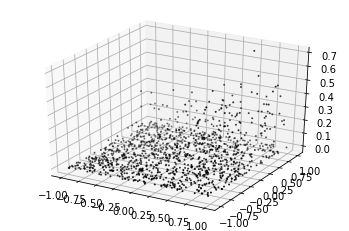

In [27]:
n_points = 5000
n_features = 3
learning_rate = 0.05
n_steps = 1000

X_train, Y_train, X_test, Y_test = gen_tobit_dataset(n_points, n_features)
output = (n_features, learning_rate, n_steps)
plot_results()